# Data Cleanup

In [25]:
# importing the libraries
from utils.DataIngestion import get_config, print_config, get_path, ingest_data
from utils.HelperFunctions import negative_check, not_in_list, out_of_bounding_box, out_of_range

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging
import numbers

### Loading Data and Configurations

In [2]:
# let's load the dataframe and configuration files
path = get_path()
print(f"Path is {path}")

config = get_config("data_preparation_config.yml")
print_config(config)

Path is D:\Machine Learning\MACHINE LEARNING PROJECTS\airbnb_price_prediction\data
Path, path_to_yaml: D:\Machine Learning\MACHINE LEARNING PROJECTS\airbnb_price_prediction\notebooks\data_preparation_config.yml


Config Value general --> {'load_from_scratch': False, 'save_raw_dataframe': False, 'save_transformed_dataframe': True, 'remove_bad_values': True}
Config Value columns --> {'categorical': ['neighbourhood_group', 'room_type'], 'continuous': ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'latitude', 'longitude'], 'date': ['last_review'], 'text': ['name', 'host_name'], 'excluded': ['price', 'id']}
Config Value category_defaults --> {'categorical': 'missing', 'continuous': 0.0, 'text': 'missing', 'date': datetime.date(2019, 1, 1), 'excluded': 'missing'}
Config Value category_invalid_replacements --> {'categorical': 'bad_categorical', 'continuous': 'bad_continuous', 'text': 'bad_text', 'date': 'bad_date', 'excluded': 'bad_excluded'}
Co

In [3]:
# loading the data
df = ingest_data(path=path,
                input_csv=config['file_names']['input_csv'],
                pickled_input_dataframe=config['file_names']['pickled_input_dataframe'],
                save_raw_dataframe=config['general']['save_raw_dataframe'],
                load_from_scratch=config['general']['load_from_scratch'])
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

### General Cleaning 

#### Replacing Numeric and Categorical Variables

In [5]:
def replace_if_not_in_list(x, replace_x, lst):
    ''' check if a value is in a list
    Args:
        x: value to check
        replace_x: replacement value
        lst: list in which to check for the value
    Returns: 
        x if value is in not in list, replace_x otherwise
    '''
    if x in lst:
        return x
    else:
        return replace_x

In [6]:
def replace_if_non_numeric(x, replace_x):
    ''' check if a value is non-numeric and replace if so
    Args:
        x: value to check
        replace_x: replacement value
    Returns: 
        x if value is numeric, replace_x otherwise
    '''
    if isinstance(x, numbers.Number):
        return x
    else:
        return replace_x

In [7]:
def replace_if_negative(x, replace_x):
    ''' checks if a value is negative if so replaces it
    Args:
        x: value to check
        replace_x: replacement value
    Returns: 
        x if value is not negative, replace_x otherwise
    '''
    if x >= 0:
        return x
    else:
        return replace_x

In [8]:
# main function to replace invalid values
def replace_invalid_values(df, columns, valid_values, invalid_value_replacements, non_neg_continuous):
    ''' replace invalid with placeholders
    Args:
        df: dataframe for assessment
        columns: dictionary of column names by category
        valid_values: dictionary of valid values for categorical columns
        invalid_value_replacements: dictionary of replacement values
        non_neg_continuous: list of continuous columns with only non-negative values as valid
    Returns:
        df: updated dataframe
    '''
    # categorical columns 
    for col in columns['categorical']:
        print(f"Non valid values in {col}: {df[col].apply(lambda x: not_in_list(x, valid_values[col])).sum()}")
        df[col] = df[col].apply(lambda x: replace_if_not_in_list(x, invalid_value_replacements['categorical'], valid_values[col]))
        
    # continuous columns
    for col in columns['continuous']:
        # replace non-numeric values
        df[col] = df[col].apply(lambda x: replace_if_non_numeric(x, invalid_value_replacements['continuous']))
        # replace if negative
        if col in non_neg_continuous:
            df[col] = df[col].apply(lambda x: replace_if_negative(x, invalid_value_replacements['continuous']))
            
    return df

#### Replacing Geospatial Variables

In [9]:
def replace_if_outside_bounding_box(latitude, longitude, replace_lat, replace_long, bounding_box):
    ''' check whether longitude and latitude values are outside bounding box
    Args:
        latitude: latitude portion of location
        longitude: longitude portion of location
        replace_lat: replacement value for latitude
        replace_long: replacement value for longitude
        bounding_box: dictionary with max and min value to compare to.
    Returns:
        latitude, longitude: 1 if out of range, 0 otherwise
    '''
    if (latitude > bounding_box['max_lat'] or latitude < bounding_box['min_lat']) \
    or (longitude > bounding_box['max_long'] or longitude < bounding_box['min_long']):
        latitude = replace_lat
        longitude = replace_long
    return (latitude, longitude)

In [10]:
# the main function to replace geospatial data
def geo_replacement(df, replace_lat, replace_long, bounding_box):
    ''' assess the geospatial data by checking values of longitude and latitude
    Args:
        df: dataframe to assess
        replace_lat: replacement for latitude value
        replace_long: replacement for longitude value
        bounding_box: dictionary of max and min values of bounding box
    Returns:
        df: updated dataframe
    '''
    df['latitude', 'longitude'] = df.apply(lambda x: replace_if_outside_bounding_box(x.latitude, x.longitude, replace_lat, replace_long, bounding_box), axis=1)
    return df


### Master Cell

In [11]:
print(f"Columns: {config['columns']}")
print("-" * 80)
print(f"Category defaults: {config['category_defaults']}")

Columns: {'categorical': ['neighbourhood_group', 'room_type'], 'continuous': ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'latitude', 'longitude'], 'date': ['last_review'], 'text': ['name', 'host_name'], 'excluded': ['price', 'id']}
--------------------------------------------------------------------------------
Category defaults: {'categorical': 'missing', 'continuous': 0.0, 'text': 'missing', 'date': datetime.date(2019, 1, 1), 'excluded': 'missing'}


In [13]:
# replacing invalid values
df = replace_invalid_values(df=df,
                           columns=config['columns'],
                           valid_values=config['valid_values'],
                           invalid_value_replacements=config['category_invalid_replacements'],
                           non_neg_continuous=config['non_negative_continuous'])

Non valid values in neighbourhood_group: 0
Non valid values in room_type: 0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [15]:
# replacing geospatial data
df = geo_replacement(df, config['latitude_replacement'], config['longitude_replacement'], config['bounding_box'])

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [18]:
# checking the number of null values now:
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                     0
calculated_host_listings_count        0
availability_365                      0
(latitude, longitude)                 0
dtype: int64

In [20]:
# Let's fill the NA values:
df['last_review'].fillna("NotReviewed", inplace=True)
df['host_name'].fillna("NoName", inplace=True)
df['name'].fillna("NoName", inplace=True)

# checking null values
df.isnull().sum()

id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
(latitude, longitude)             0
dtype: int64

###### Let's look at the price:

In [22]:
df['price'].describe()

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

- *The max value of 'Price' is 10000.*
- *This was either an error during input of the data or these properties are super expensive.*

*Let's explore more to find out.*

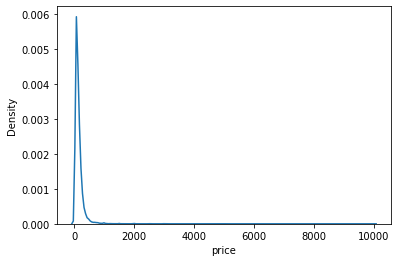

In [28]:
sns.kdeplot(x='price', data=df);

<AxesSubplot:>

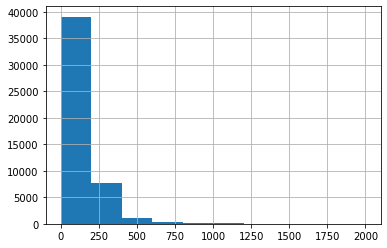

In [30]:
# Let's look at prices less than 2000
df[df['price'] < 2000]['price'].hist();

In [32]:
# Let's see how many listings are priced at greater than 2000
df[df['price'] > 2000]['price'].count()

86

In [33]:
# Dropping these values
df = df[df['price'] < 2000]

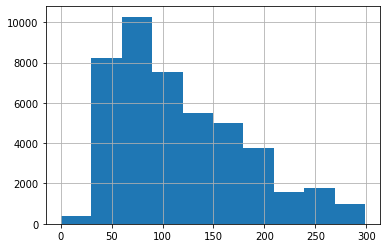

In [35]:
# We need to take a threshold value
df[df['price'] < 300]['price'].hist();

- *We see more of a Gaussian Distribution around after setting threshold value to 300.*

In [36]:
df[df['price'] < 300]['price'].count()

44977

- *We still ahve 44977 records after setting the threshold to 300*
- *We treat any price above 300 as outliers and we can drop those records*

In [38]:
# dropping the price outliers
df = df[df['price'] < 300]
df.shape

(44977, 17)

In [40]:
# let's look at the statistics of the price column again
df['price'].describe()

count    44977.000000
mean       116.017520
std         63.095803
min          0.000000
25%         65.000000
50%        100.000000
75%        150.000000
max        299.000000
Name: price, dtype: float64

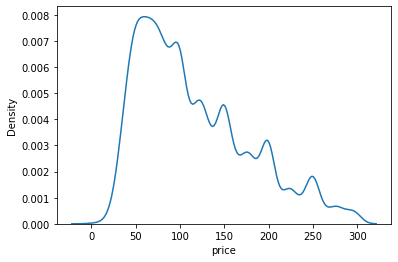

In [44]:
# distribution:
sns.kdeplot('price', data=df);

- Average Price: 116.0, Price varies between 0 and 299

###### Let's look at the Minimum Nights

In [41]:
# statistical summary
df['minimum_nights'].describe()

count    44977.000000
mean         6.904996
std         19.891975
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       1250.000000
Name: minimum_nights, dtype: float64

- The range is between 0 to 1250.
- The maximum value of 1250 is not correct.

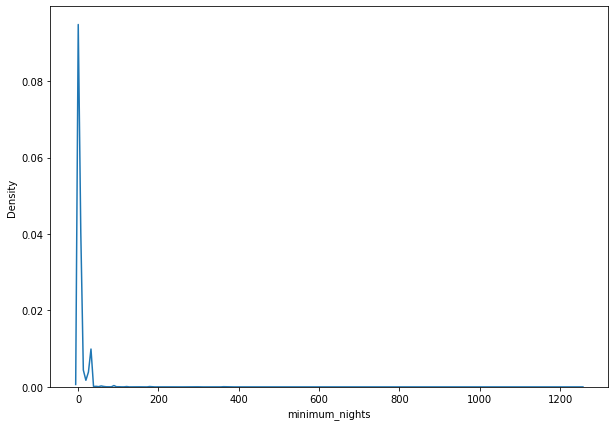

In [45]:
# distribution of the data:
fig, ax = plt.subplots(figsize=(10, 7))
sns.kdeplot('minimum_nights', data=df, ax=ax);

- We see that almost all the values are less than 50.

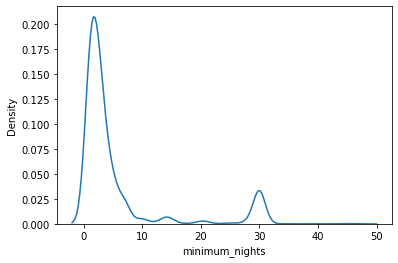

In [52]:
# lets look at distribution of minimum nights less than 50
sns.kdeplot(df[df['minimum_nights'] < 50]['minimum_nights']);

- We see jumps at around ~1 and then at ~15 and then at ~30.
- We will replace all values greater than 30 to 30.

In [54]:
df.loc[(df['minimum_nights'] > 30), 'minimum_nights'] = 30

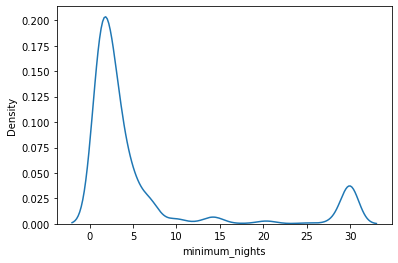

In [56]:
# lets look at the distribution now
sns.kdeplot('minimum_nights', data=df);

##### Let's analyze the Availabilty column:

In [57]:
df['availability_365'].describe()

count    44977.000000
mean       108.634502
std        130.039172
min          0.000000
25%          0.000000
50%         38.000000
75%        215.000000
max        365.000000
Name: availability_365, dtype: float64

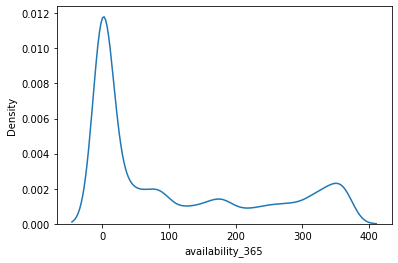

In [58]:
# distribution:
sns.kdeplot('availability_365', data=df);

- The range looks fine -> from 0 to 365.
- The distribution is positively or right skewed.

##### Replacing bad values

In [69]:
df.loc[(df['reviews_per_month'] == 'bad_continuous'), "reviews_per_month"] = 0

In [73]:
(df.reviews_per_month == 'bad_continuous').sum()

0

##### Dropping the columns which are not useful for Modelling

In [75]:
# list of columns
list(df)

['id',
 'name',
 'host_id',
 'host_name',
 'neighbourhood_group',
 'neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'last_review',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 ('latitude', 'longitude')]

In [85]:
# columns to drop
cols_to_drop = ['id', 'name', 'host_id', 'host_name', 'latitude', 'longitude', 'last_review']

In [88]:
df = df.drop(cols_to_drop, axis=1)

In [104]:
df = df[['neighbourhood_group',
 'neighbourhood',
 'room_type',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']]

In [105]:
# after removing cols:
list(df)

['neighbourhood_group',
 'neighbourhood',
 'room_type',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']

##### Checking the Data Types of all columns:

In [106]:
df.dtypes

neighbourhood_group                object
neighbourhood                      object
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

- `review_per_month` should be int64 not object.

In [107]:
# converting reviews_per_month to integer
df['reviews_per_month'] = pd.to_numeric(df['reviews_per_month'])

In [108]:
df.dtypes

neighbourhood_group                object
neighbourhood                      object
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

##### Saving transformed data:

In [109]:
if config['general']['save_transformed_dataframe']:
    print("Path:", path)
    filename = os.path.join(path, config['file_names']['pickled_output_dataframe'])
    print("File Name:", filename)
    df.to_pickle(filename)

Path: D:\Machine Learning\MACHINE LEARNING PROJECTS\airbnb_price_prediction\data
File Name: D:\Machine Learning\MACHINE LEARNING PROJECTS\airbnb_price_prediction\data\AB_NYC_2019_output_nov8.pkl


In [110]:
# loading the pickled output file
pickled_output_file = pd.read_pickle(os.path.join(path, config['file_names']['pickled_output_dataframe']))
pickled_output_file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44977 entries, 0 to 48894
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             44977 non-null  object 
 1   neighbourhood                   44977 non-null  object 
 2   room_type                       44977 non-null  object 
 3   price                           44977 non-null  int64  
 4   minimum_nights                  44977 non-null  int64  
 5   number_of_reviews               44977 non-null  int64  
 6   reviews_per_month               44977 non-null  float64
 7   calculated_host_listings_count  44977 non-null  int64  
 8   availability_365                44977 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 3.4+ MB
